In [1]:
import rootutils
import random
import numpy as np
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import cv2
from functools import partial 
from PIL import Image
from torchvision.io import write_video
from torchvision.transforms import PILToTensor
path = '/idiap/temp/pvuillecard/projects/gaze_pretrain/'
rootutils.setup_root(path, indicator=".project-root", pythonpath=True)


PosixPath('/remote/idiap.svm/temp.perception01/pvuillecard/projects/gaze_pretrain')

In [2]:
from gaze_module.data.components.gaze_dataset import (
    Gaze360Image, 
    Gaze360Video,
    GFIEImage,
    GFIEVideo,
    MPSGazeImage, 
    GazeFollowImage,
    ChildPlayImage,
    EyediapImage,
    EyediapVideo,
    VATImage,
    VATVideo,
    MPIIFaceImage,
    GazeAnnotation
)

from gaze_module.data.components.transforms import (BboxRandomJitter,BboxReshape,Crop,
                                  ToTensor, Normalize,CropRandomResize,
                                  ToImage, HorizontalFlip,ColorJitter,RandomGaussianBlur)
from gaze_module.data.combined_datamodule import ConcatenateDataModule, SimpleDataModule

%load_ext autoreload
%autoreload 2



In [3]:
def draw_arrow(img, yaw_pitch, d, color, thickness_float=0.01):
    w = img.shape[1]
    h = img.shape[0]

    pos = [w // 2, h // 2]
    length = w * d
    thickness = max(int(w * thickness_float), 1)
    # dx = -length * np.sin(pitch_yaw[1]) * np.cos(pitch_yaw[0])
    # dy = -length * np.sin(pitch_yaw[0])
    dx = -length * np.sin(yaw_pitch[0]) * np.cos(yaw_pitch[1])
    dy = -length * np.sin(yaw_pitch[1])

    cv2.arrowedLine(
        img,
        tuple(np.round(pos).astype(np.int32)),
        tuple(np.round([pos[0] + dx, pos[1] + dy]).astype(int)),
        color,
        thickness,
        cv2.LINE_AA,
        tipLength=0.2,
    )
    return img

def draw_arrow2D(img, gaze_xy, d, color, thickness_float=0.01):
    w = img.shape[1]
    h = img.shape[0]

    pos = [w // 2, h // 2]
    length = w * d
    thickness = max(int(w * thickness_float), 1)
    # dx = -length * np.sin(pitch_yaw[1]) * np.cos(pitch_yaw[0])
    # dy = -length * np.sin(pitch_yaw[0])
    gaze_dir = gaze_xy / np.linalg.norm(gaze_xy)
    dx = -length * gaze_dir[0]
    dy = -length * gaze_dir[1]

    cv2.arrowedLine(
        img,
        tuple(np.round(pos).astype(np.int32)),
        tuple(np.round([pos[0] + dx, pos[1] + dy]).astype(int)),
        color,
        thickness,
        cv2.LINE_AA,
        tipLength=0.2,
    )
    return img

In [52]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        # CropRandomResize(
                        #     output_size=224, 
                        #     scale=(0.9,1),
                        #     ratio=(0.9,1.1)),
                        # HorizontalFlip(verbose = True),
                        # ColorJitter(
                        #     brightness=(0.5, 1.5),
                        #     contrast=(0.5, 1.5),
                        #     saturation=(0.0, 1.5),
                        #     hue=None,
                        #     p=1,
                        #     verbose = True),
                        # RandomGaussianBlur(
                        #     radius=7,
                        #     sigma=(0.2,2), 
                        #     p=1,
                        #     verbose = True),
                        # ToTensor(),
                        # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset = Gaze360Image(
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/gaze360_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/samples/image_samples.csv',
    split='train',
    head_bbox_name='head_bbox_yolo',
    transform=transorm_simple,
)

BboxReshape is square  True 0.1


yaw pitch tensor([11.6586,  1.6881])
vector tensor([ 0.2020,  0.0295, -0.9789]) tensor(1.)


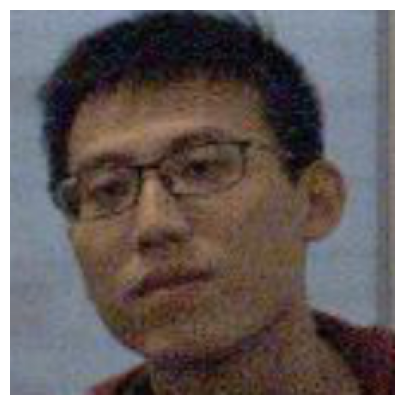

In [68]:
sample = dataset[np.random.randint(len(dataset))]
# plot the image 
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))
print('yaw pitch',sample['task_gaze_yawpitch']*180/np.pi)
print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(image)
# save the image in high resolution
img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite('paper_images/gaze360_2.png',img)
for i in range(2):
    for j in range(2): 
        cv2.imwrite(f'paper_images/gaze360_2_{i}_{j}.png',img[i*112:(i+1)*112,j*112:(j+1)*112])


In [69]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                    ])

dataset = Gaze360Video(
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/gaze360_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/samples/image_samples.csv',
    split='train',
    head_bbox_name='head_bbox_yolo',
    transform=transorm_simple,
    strategy='followed'
)

BboxReshape is square  True 0.1


In [70]:
length = len(dataset)
print(length)

42310


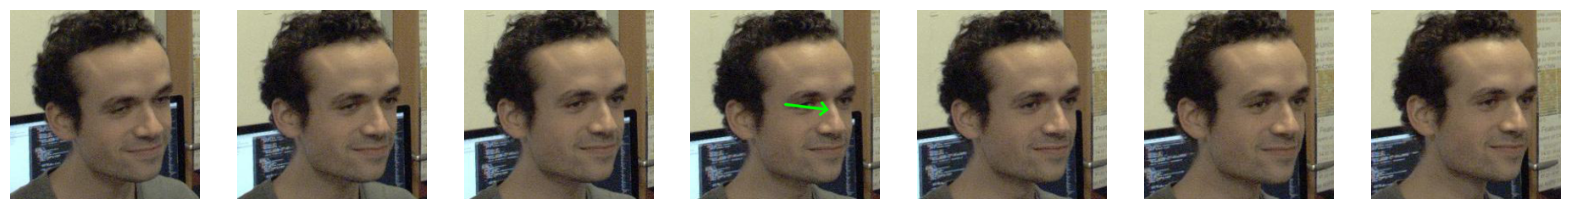

In [91]:
sample = dataset[np.random.randint(len(dataset))]

# plot the image 
#print(sample)
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for i, image in enumerate(sample['images']):
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if i == 3:
        image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))
    axes[i].imshow(image)
    axes[i].axis('off')

In [21]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset = GFIEImage(
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/sample/samples.csv',
    split='validation',
    head_bbox_name=None,
    transform=transorm_simple,
)

BboxReshape is square  True 0.1


yaw pitch tensor([ 89.2158, -88.3524])
vector tensor([ 2.8750e-02, -9.9959e-01, -3.9351e-04]) tensor(1.)


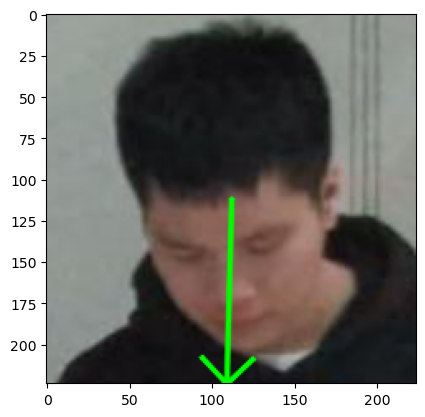

In [561]:
sample = dataset[np.random.randint(len(dataset))]
# plot the image 
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))
print('yaw pitch',sample['task_gaze_yawpitch']*180/np.pi)
print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
plt.imshow(image)

In [5]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset = GFIEVideo(
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/sample/samples.csv',
    split='validation',
    head_bbox_name=None,
    transform=transorm_simple,
    strategy='followed'
)

BboxReshape is square  True 0.1


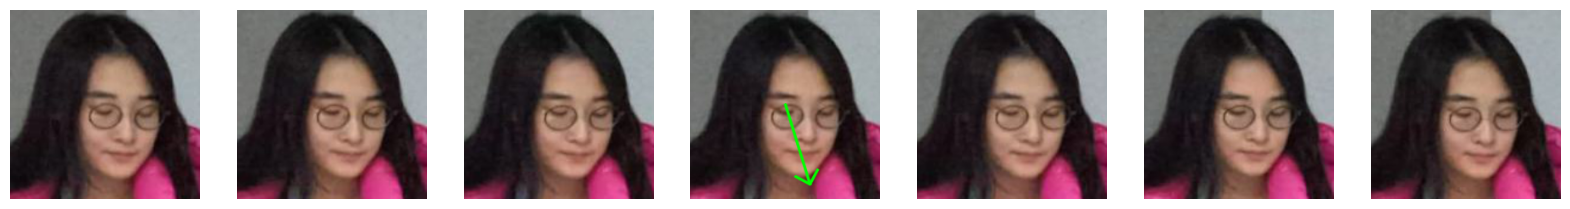

In [46]:
sample = dataset[np.random.randint(len(dataset))]

# plot the image 
#print(sample)
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for i, image in enumerate(sample['images']):
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if i == 3:
        image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))
    axes[i].imshow(image)
    axes[i].axis('off')

In [6]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset_mps = MPSGazeImage(
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/MPSGaze/mpsgaze_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/MPSGaze/mpsgaze_file.csv',
    split='train',
    head_bbox_name=None,
    transform=transorm_simple,
)

BboxReshape is square  True 0.1


In [8]:
len(dataset_mps)

24282

yaw pitch tensor([-21.9844, -15.8767])
vector tensor([-0.3601, -0.2736, -0.8919]) tensor(1.)


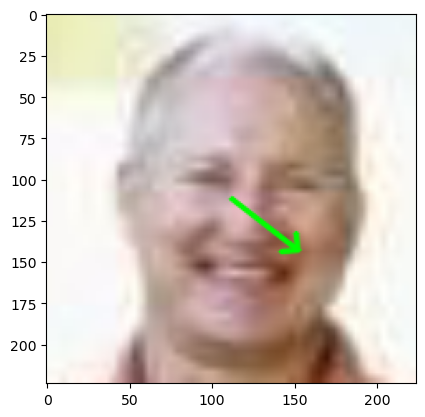

In [10]:
sample = dataset_mps[np.random.randint(len(dataset_mps))]
# plot the image 
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))
print('yaw pitch',sample['task_gaze_yawpitch']*180/np.pi)
print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
plt.imshow(image)

In [113]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.9),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        #Crop(224),
                        CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset_follow = GazeFollowImage(
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/gazefollow_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/gazefollow_file.csv',
    split='validation',
    head_bbox_name=None,
    transform=transorm_simple,
)

BboxReshape is square  True 0.9


/remote/idiap.svm/temp.perception01/pvuillecard/projects/gaze_pretrain/gaze_module/data/components/gaze_dataset.py:54: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  self.sample = pd.read_csv(self.sample_path)


frame_id 24163
clip_id 24163
person_id 41465
data_id 4
head_bbox tensor([[ 27.1000,  47.5786, 144.9000, 165.3786]], dtype=torch.float64)
bbox_strategy fixed_center
task_gaze_yawpitch -1
task_gaze_vector tensor([-0.2359, -0.9718])
yaw pitch -57.29577951308232
vector tensor([-0.2359, -0.9718]) tensor(1.)


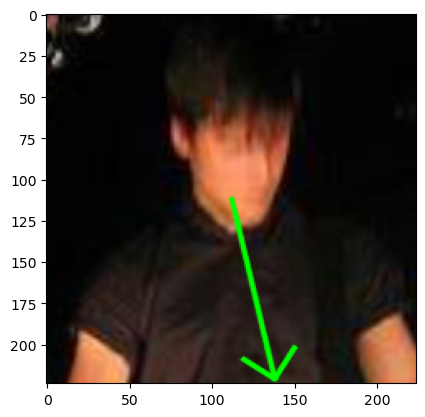

In [114]:
sample = dataset_follow[np.random.randint(len(dataset_follow))]
# plot the image 
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()

for k,v in sample.items():
    if k != 'images':
        print(k,v)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = draw_arrow2D(image, sample['task_gaze_vector'], 0.5, (0, 255, 0))
print('yaw pitch',sample['task_gaze_yawpitch']*180/np.pi)
print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
plt.imshow(image)

In [17]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset = EyediapVideo(
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Eyediap/eyediap_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Eyediap/eyediap_file.csv',
    split='test',
    head_bbox_name=None,
    transform=transorm_simple,
)

BboxReshape is square  True 0.1


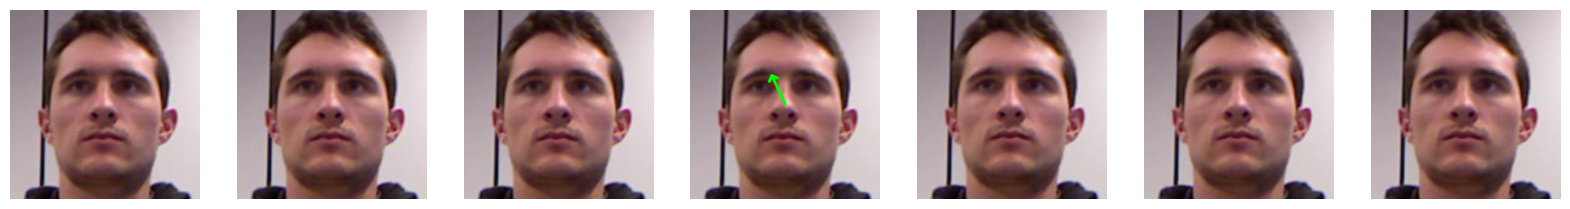

In [75]:
sample = dataset[np.random.randint(len(dataset))]

# plot the image 
#print(sample)
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for i, image in enumerate(sample['images']):
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if i == 3:
        image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))
    axes[i].imshow(image)
    axes[i].axis('off')

In [4]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.0),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset_eyediap = EyediapImage(
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Eyediap/eyediap_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Eyediap/eyediap_file.csv',
    split='test',
    head_bbox_name=None,
    transform=transorm_simple,
)

BboxReshape is square  True 0.0


In [26]:
sample = dataset_eyediap[np.random.randint(len(dataset_eyediap))]
# plot the image 
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))

print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
plt.imshow(image)

NameError: name 'dataset_eyediap' is not defined

In [10]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset= MPIIFaceImage(
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/MPIIFace/mpiiface_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/MPIIFace/mpiiface_file.csv',
    split='test',
    head_bbox_name=None,
    transform=transorm_simple,
)

BboxReshape is square  True 0.1


vector tensor([-0.2233, -0.1761, -0.9587]) tensor(1.)


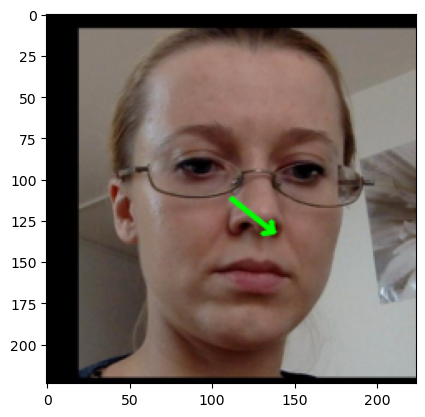

In [98]:
sample = dataset[np.random.randint(len(dataset))]
# plot the image 
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))

print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
plt.imshow(image)

frame_id 1216
clip_id 166
person_id 1
data_id 5
head_bbox tensor([[574.3000, 213.4282, 941.7000, 580.8282]], dtype=torch.float64)
bbox_strategy fixed_center
task_gaze_yawpitch -1
task_gaze_vector tensor([-0.7726, -0.6349])


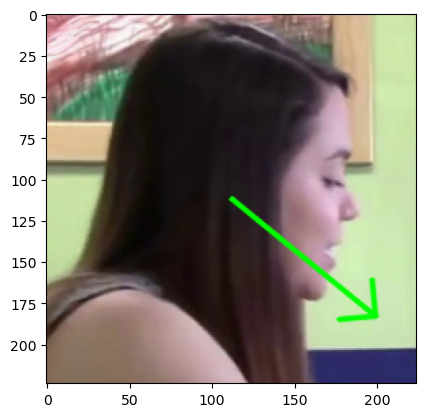

In [78]:
sample = dataset_follow[np.random.randint(len(dataset_follow))]
# plot the image
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()

for k,v in sample.items():
    if k != 'images':
        print(k,v)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
if sample['task_gaze_vector'] is not None:
    image = draw_arrow2D(image, sample['task_gaze_vector'], 0.5, (0, 255, 0))
# print('yaw pitch',sample['task_gaze_yawpitch']*180/np.pi)
# print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
plt.imshow(image)


In [ ]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.0),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset_childplay = ChildPlayImage(
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/ChildPlay/childplay_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/ChildPlay/samples/sample_pred.csv',
    split='all',
    head_bbox_name=None,
    transform=transorm_simple,
)

In [86]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
additional_gaze = GazeAnnotation(
      location = '/idiap/temp/pvuillecard/projects/face_analyser/datasets/VAT/annotations/gaze_pseudo_omnivoreV_gaze360_gaze360v.pkl'
)

dataset_vat = VATImage(
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/VAT/vat_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/VAT/vat_file.csv',
    split='train',
    head_bbox_name=None,
    transform=transorm_simple,
    additonal_data = [additional_gaze]
)

BboxReshape is square  True 0.1


True

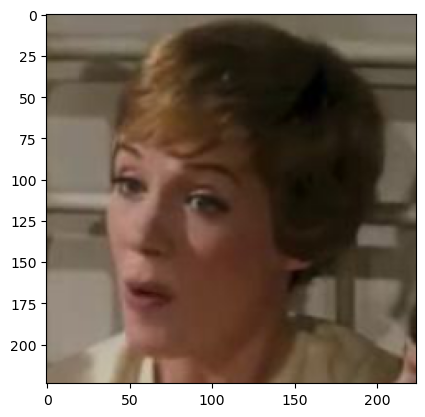

In [102]:
sample = dataset_vat[np.random.randint(len(dataset_vat))]
# plot the image 
#print(sample)
image = sample['images'][0].permute(1, 2, 0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))

#print('vector',sample['task_gaze_vector'],sample['task_gaze_vector'].norm())
plt.imshow(image)
cv2.imwrite('paper_images/vat.png',cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [107]:


transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

additional_gaze = GazeAnnotation(
      location = '/idiap/temp/pvuillecard/projects/face_analyser/datasets/VAT/annotations/gaze_pseudo_omnivoreV_gaze360_gaze360v.pkl'
)
dataset_vat = VATVideo(
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/VAT/vat_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/VAT/vat_file.csv',
    split='train',
    head_bbox_name=None,
    transform=transorm_simple,
    additonal_data = [additional_gaze],
    strategy='followed'
)
print(len(dataset_vat))

BboxReshape is square  True 0.1
41946


['clip_00000065_frame_00002912_face_00000002', 'clip_00000065_frame_00002915_face_00000002', 'clip_00000065_frame_00002918_face_00000002', 'clip_00000065_frame_00002921_face_00000002', 'clip_00000065_frame_00002924_face_00000002', 'clip_00000065_frame_00002927_face_00000002', 'clip_00000065_frame_00002930_face_00000002']


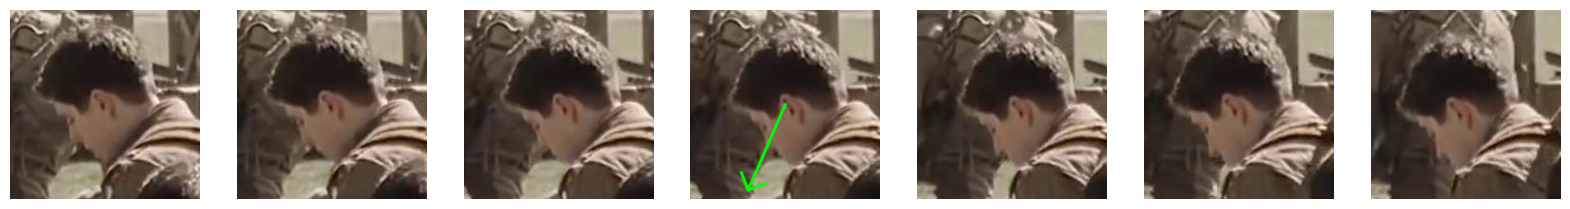

In [111]:
sample = dataset_vat[np.random.randint(len(dataset_vat))]

# plot the image 
#print(sample)
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for i, image in enumerate(sample['images']):
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if i == 3:
        image = draw_arrow(image, sample['task_gaze_yawpitch'], 0.5, (0, 255, 0))
    axes[i].imshow(image)
    axes[i].axis('off')

In [12]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        #Crop(224),
                        CropRandomResize(224),
                        HorizontalFlip(),
                        ToTensor(),
                        # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset_gaze360 = partial(Gaze360Image,
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/gaze360_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/samples/image_samples.csv',
    head_bbox_name='head_bbox_yolo',
)

dataset_gfie = partial(GFIEImage,
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/sample/samples.csv',
    head_bbox_name=None,
)

In [13]:
dataset = ConcatenateDataModule(
    datasets = [dataset_gaze360, dataset_gfie],
    train_transform = transorm_simple,
    test_transform= transorm_simple,
    batch_size = 2,
    num_workers = 2,
)
dataset.setup()

In [50]:
train_loader = dataset.train_dataloader()
val_loader = dataset.val_dataloader()
test_loader = dataset.test_dataloader()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1


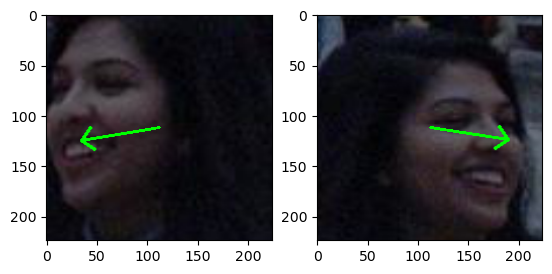

In [74]:
for batch in val_loader:
    
    images = batch['images']
    fig,ax = plt.subplots(1,2)
    for i in range(len(ax)):
        print(i)
        image = images[i][0].permute(1, 2, 0).numpy()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = draw_arrow(image, batch['task_gaze'][i], 0.5, (0, 255, 0))
        ax[i].imshow(image)
    
    plt.imshow(image)
    break

In [12]:
# check for invalide values in gazefollow 
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        #Crop(224),
                        CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])


dataset_follow = GazeFollowImage(
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/gazefollow_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/gazefollow_file.csv',
    split='train',
    head_bbox_name=None,
    transform=transorm_simple,
)


BboxReshape is square  True 0.1


/remote/idiap.svm/temp.perception01/pvuillecard/projects/gaze_pretrain/gaze_module/data/components/gaze_dataset.py:47: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  self.sample = pd.read_csv(self.sample_path)


In [13]:
# create a dataloader
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
train_loader = DataLoader(dataset_follow, batch_size=80, shuffle=True, num_workers=2)

count_nan = 0
for batch in tqdm(train_loader, total=len(train_loader)):
    # for k,v in batch.items():
    #     if k != 'images':
    #         print(k,v)
    # break
    # count the number of nan in the gaze vector
    for gaze in batch['task_gaze_vector']:
        if torch.isnan(gaze).any():
            count_nan += torch.isnan(gaze).sum().item()
            print(count_nan)
    


 10%|▉         | 132/1356 [00:16<02:32,  8.02it/s]


KeyboardInterrupt: 

In [4]:
transorm_simple = Compose([    
                        BboxReshape( square = True, ratio = 0.1),
                        #BboxRandomJitter( jitter_ratio = 0.1),
                        ToImage(),
                        Crop(224),
                        #CropRandomResize(224),
                        #HorizontalFlip(),
                        #ToTensor(),
                        # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

dataset_gazefollow = partial(GazeFollowImage,
    data_location=None,
    image_db_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/gazefollow_image_database.pkl',
    sample_path='/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/gazefollow_file.csv',
    head_bbox_name=None,
)

dataset = SimpleDataModule(
    datasets = [dataset_gazefollow],
    test_transform= transorm_simple,
    batch_size = 2,
    num_workers = 2,
)

dataset.setup()
predict_loader = dataset.predict_dataloader()

BboxReshape is square  True 0.1


/remote/idiap.svm/temp.perception01/pvuillecard/projects/gaze_pretrain/gaze_module/data/components/gaze_dataset.py:47: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  self.sample = pd.read_csv(self.sample_path)


In [9]:
# test the size of the dataset 
print(len(predict_loader)*2)

117712


2
torch.Size([2, 3, 224, 224])
0
1


IndexError: list index out of range

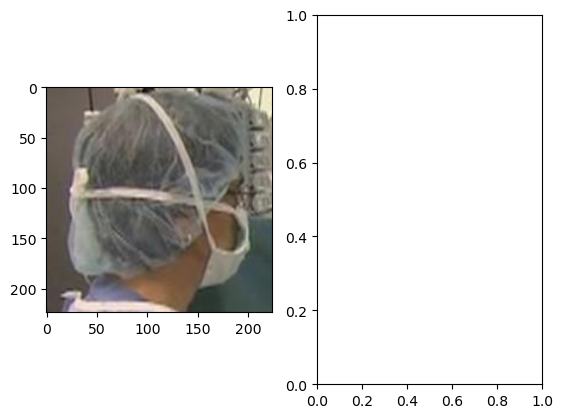

In [20]:

for batch in predict_loader:
    
    images = batch['images']
    print(len(batch['task_gaze_vector']))
    print(batch['images'][0].shape)
    fig,ax = plt.subplots(1,2)
    for i in range(len(ax)):
        print(i)
        image = images[i][0].permute(1, 2, 0).numpy()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #image = draw_arrow(image, batch['task_gaze'][i], 0.5, (0, 255, 0))
        ax[i].imshow(image)
    
    plt.imshow(image)
    break

In [8]:
# load gaze360 video dataset
import pickle

with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_clip_database.pkl', 'rb') as f:
    data = pickle.load(f)

with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_image_database.pkl', 'rb') as f:
    image_db = pickle.load(f)

In [9]:
# randomly select a sample video 

clip_keys = list(data.keys())
clip_key = random.choice(clip_keys)
clip = data[clip_key]
print(clip.keys())

dict_keys(['clip_id', 'clip_path', 'fps', 'frames', 'image_paths', 'image_ids', 'nb_frames', 'start', 'end', 'other'])


In [10]:
# load the image dataset torch resize them to 224 and save them as a video 

video_output = []
for image_id in clip['image_ids']:
    image_info = image_db[image_id]
    print(image_info.keys())
    image = cv2.imread(image_info['image_path_crop'])
    image = cv2.resize(image, (224, 224))
    video_output.append(image)
    
video_output = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in video_output]
video_output = [Image.fromarray(frame) for frame in video_output]
video_output = [PILToTensor()(frame) for frame in video_output]
video_output = torch.stack(video_output)
print(video_output.shape)
video_output = video_output.permute(0, 2, 3, 1)

dict_keys(['image_path', 'clip_path', 'frame', 'clip_name', 'clip_id', 'other', 'image_width', 'image_height', 'image_path_crop'])


RuntimeError: No active exception to reraise